# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from IPython.display import display
import itertools

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2024-04-28 10:31:45.727046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-28 10:31:45.727089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-28 10:31:45.728449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Image Data Loading Function

In [2]:
def load_data(data_dir, target_size=(224, 224), batch_size=32, shuffle=True):
    datagen = ImageDataGenerator(rescale=1./255)
    data_generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle 
    )
    return data_generator

# EfficientNet-B0 Model Creation Function

In [3]:
def create_model(input_shape, num_classes, learning_rate=0.001):
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Model Training Function with Callbacks

In [4]:
def train_model(model, train_generator, val_generator, epochs=30):
    model_checkpoint = ModelCheckpoint("My_Aug-Efficient-B0.keras", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, callbacks=[model_checkpoint, reduce_lr])
    return history

# Model Evaluation Function

In [5]:
def evaluate_model(model, test_generator):
    loss, acc = model.evaluate(test_generator, verbose=0)
    print("Test Accuracy:", np.round(acc * 100, 2))
    return loss, acc


# Confusion Matrix Plotting Function

In [6]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Function for Predicting Random Image

In [7]:
def predict_random_image(model, test_generator, class_names):
    num_test_samples = len(test_generator.filenames)
    random_index = np.random.randint(0, num_test_samples)

    random_image_path = test_generator.filepaths[random_index]
    random_image = cv2.imread(random_image_path)
    random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    random_image = cv2.resize(random_image, (224, 224))
    random_image = random_image.astype('float32') / 255.0

    plt.imshow(random_image)
    plt.axis('off')
    plt.title("Random Image to Predict")
    plt.show()

    true_label = test_generator.filenames[random_index]
    print("Actual label:", true_label)

    prediction_prob = model.predict(np.expand_dims(random_image, axis=0))
    predicted_label_index = np.argmax(prediction_prob)
    
    class_names = list(class_names)  
    predicted_label = class_names[predicted_label_index]
    print("Predicted label:", predicted_label)

# Data Loading and Preprocessing Pipeline

In [8]:
train_generator = load_data("/kaggle/input/myrice-diseasesfinalize-aug/Augmented-Ds/train")
val_generator = load_data("/kaggle/input/myrice-diseasesfinalize-aug/Augmented-Ds/val")
test_generator = load_data("/kaggle/input/myrice-diseasesfinalize-aug/Augmented-Ds/test", shuffle=False)

Found 10245 images belonging to 4 classes.
Found 406 images belonging to 4 classes.
Found 411 images belonging to 4 classes.


# Model Creation and Training

In [9]:
model = create_model((224, 224, 3), num_classes=len(train_generator.class_indices), learning_rate=0.001)
history = train_model(model, train_generator, val_generator)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714300466.292744     183 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714300466.406170     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


166/321 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - accuracy: 0.7122 - loss: 0.6757   

W0000 00:00:1714300631.856935     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7470 - loss: 0.6047

W0000 00:00:1714300745.034803     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.30542, saving model to My_Aug-Efficient-B0.keras


W0000 00:00:1714300763.226632     183 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


321/321 ━━━━━━━━━━━━━━━━━━━━ 400s 930ms/step - accuracy: 0.7472 - loss: 0.6044 - val_accuracy: 0.3054 - val_loss: 1.2328 - learning_rate: 0.0010
Epoch 2/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.8701 - loss: 0.3527
Epoch 2: val_accuracy improved from 0.30542 to 0.62315, saving model to My_Aug-Efficient-B0.keras
321/321 ━━━━━━━━━━━━━━━━━━━━ 168s 514ms/step - accuracy: 0.8701 - loss: 0.3526 - val_accuracy: 0.6232 - val_loss: 1.1850 - learning_rate: 0.0010
Epoch 3/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9106 - loss: 0.2582
Epoch 3: val_accuracy improved from 0.62315 to 0.77094, saving model to My_Aug-Efficient-B0.keras
321/321 ━━━━━━━━━━━━━━━━━━━━ 169s 517ms/step - accuracy: 0.9106 - loss: 0.2582 - val_accuracy: 0.7709 - val_loss: 0.8820 - learning_rate: 0.0010
Epoch 4/30
321/321 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9105 - loss: 0.2619
Epoch 4: val_accuracy improved from 0.77094 to 0.91626, saving model to My_Aug-Efficient-B0.keras
321/321

# Save the Model

In [10]:
model.save("/kaggle/working/My_Aug-Efficient-B0.h5")


# Evaluate Model Performance on Original-Ds Test set

In [11]:
loss, acc = evaluate_model(model, test_generator)

Test Accuracy: 95.62


W0000 00:00:1714305837.637020     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Training History Visualization

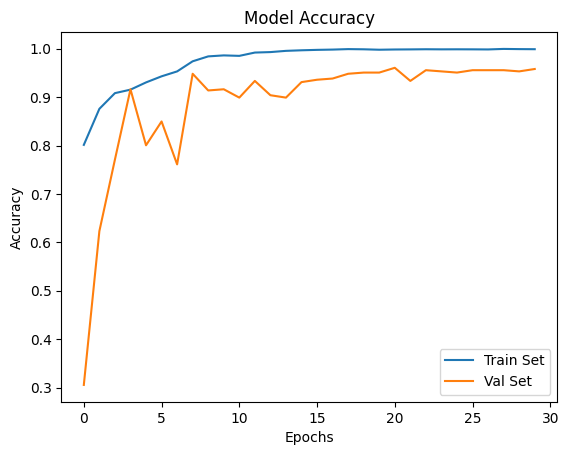

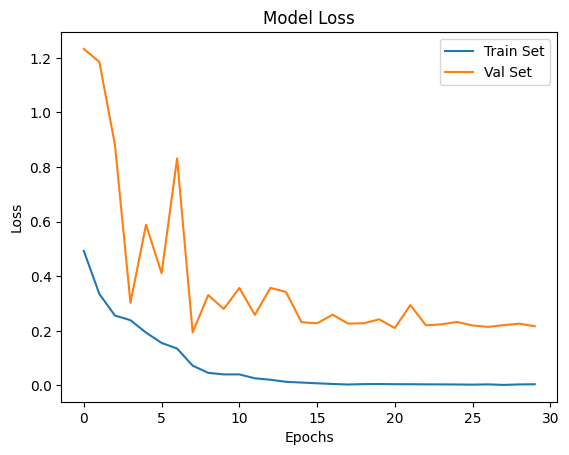

In [12]:
plt.plot(history.history['accuracy'], label='Train Set')
plt.plot(history.history['val_accuracy'], label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Set')
plt.plot(history.history['val_loss'], label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

# Evaluate Model Predictions and Metrics

In [13]:
test_pred_prob = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_prob, axis=1)
test_true_labels = test_generator.classes
class_names = list(train_generator.class_indices.keys())
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))

 5/13 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

W0000 00:00:1714305860.799746     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 
                precision    recall  f1-score   support

Rice_BrownSpot       0.92      0.95      0.94        62
  Rice_Healthy       0.99      0.94      0.96       150
Rice_LeafBlast       0.89      0.94      0.92        99
Rice_NeckBlast       1.00      1.00      1.00       100

      accuracy                           0.96       411
     macro avg       0.95      0.96      0.95       411
  weighted avg       0.96      0.96      0.96       411



W0000 00:00:1714305873.466808     186 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# Confusion Matrix Visualization

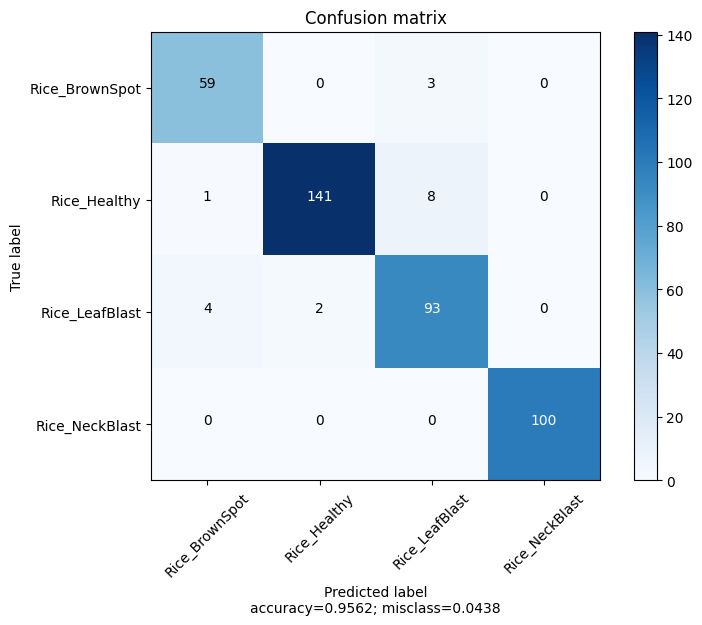

In [14]:
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
plot_confusion_matrix(conf_matrix, target_names=class_names)

# Additional Evaluation Metrics Calculation and Printing

In [15]:
precision = precision_score(test_true_labels, test_pred_labels, average='weighted')
recall = recall_score(test_true_labels, test_pred_labels, average='weighted')
f1_score = f1_score(test_true_labels, test_pred_labels, average='weighted')
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print evaluation measures
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

Precision: 0.9576330755619077
Recall: 0.9562043795620438
F1 Score: 0.9565485458686065
Sensitivity: 0.9929577464788732
Specificity: 1.0


# Predict on a Random Image from Original-Ds

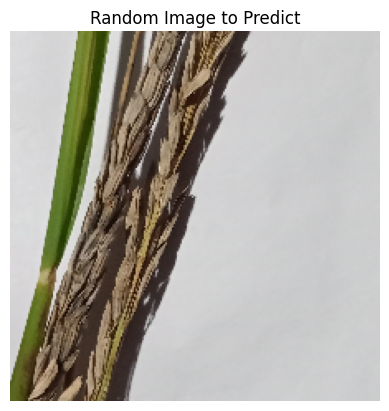

Actual label: Rice_NeckBlast/IMG20201109182008_00.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted label: Rice_NeckBlast


In [16]:
predict_random_image(model, test_generator, train_generator.class_indices.keys())